In [1]:
import sys, os, json, subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline


In [2]:
import cbm3_python_helper
cbm3_python_helper.load_cbm3_python()
import cbm3_python.simulation.projectsimulator
from cbm3_python.cbm3data import cbm3_results
from cbm3_python.cbm3data import sit_helper
standard_import_tool_plugin_path=sit_helper.load_standard_import_tool_plugin()

In [3]:
# a randomly selected growth curve from an NIR project
#format CBM3 Default Species: [vol[age0, age10, age20, ..., age260]]
gc = [
    ("Black spruce",[0,0,0,0,0,0,1,1,1,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1]),
    ("White spruce",[0,0,0,0,1,2,3,5,6,7,8,9,9,10,10,10,10,10,9,9,8,8,8,7,7,7,6]),
    ("Western white pine",[0,0,0,0,2,5,8,10,12,14,16,17,18,19,19,20,20,20,20,20,20,20,20,20,20,20,20]),
    ("Jack pine",[0,0,0,3,7,10,12,14,14,15,15,14,13,9,3,1,0,0,0,0,0,0,0,0,0,0,0]),
    ("Red pine",[0,0,3,40,92,137,171,195,213,224,230,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232]),
    ("Balsam fir",[0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
    ("Poplar/aspen",[0,0,0,3,7,10,13,15,16,17,18,17,14,7,1,0,0,0,0,0,0,0,0,0,0,0,0]),
    ("White birch",[0,0,0,1,2,3,4,4,5,5,5,5,5,4,3,1,0,0,0,0,0,0,0,0,0,0,0]),
    ("Unspecified hardwood species",[0,0,0,0,0,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2])
]



In [4]:
toolbox_path = r'C:\Program Files (x86)\Operational-Scale CBM-CFS3'
project_path = r"C:\Program Files (x86)\Operational-Scale CBM-CFS3\Projects\multicomponent\multicomponent.mdb"
results_db_path = r"C:\Program Files (x86)\Operational-Scale CBM-CFS3\Projects\multicomponent\multicomponent_results.mdb"
config_save_path =  r"C:\Program Files (x86)\Operational-Scale CBM-CFS3\Projects\multicomponent\config.json"
c = sit_helper.SITConfig(
    imported_project_path=project_path,
    initialize_mapping=True
)
c.data_config(
    age_class_size=10,
    num_age_classes=27,
    classifiers=["Leading Species", "Scenario"])

c.set_single_spatial_unit(19)
c.set_species_classifier("Leading Species")

c.add_inventory(classifier_set=["Red pine", "grouped"],
                area=1, age=0, unfccc_land_class=0)
c.add_event(classifier_set=["?","?"], disturbance_type="Wildfire", 
              time_step=150, target=30, target_type="Area", sort="SORT_BY_SW_AGE")
n_components = len(gc)
for i,g in enumerate(gc):
    default_species = g[0]
    volumes = g[1]
    c.add_yield(classifier_set=["Red pine", "grouped"],
            leading_species_classifier_value=default_species,
            values=volumes)
    
    c.add_inventory(classifier_set=[default_species, "component_{0}".format(i)],
                area=1, age=0, unfccc_land_class=0)
    c.add_yield(classifier_set=[default_species, "component_{0}".format(i)],
            leading_species_classifier_value=default_species,
            values=volumes)
    
c.import_project(standard_import_tool_plugin_path, config_save_path)
results_db_path = cbm3_python.simulation.projectsimulator.run(
    aidb_path=os.path.join(toolbox_path, "admin", "dbs", "ArchiveIndex_Beta_Install.mdb"), 
    project_path=os.path.abspath(project_path), 
    toolbox_installation_dir=toolbox_path,
    cbm_exe_path=os.path.join(toolbox_path, "admin", "executables"),
    results_database_path= results_db_path)

In [5]:
results = cbm3_results.load_pool_indicators(results_db_path,classifier_set_grouping=True)

In [7]:
markers = ["o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d"]
cols = ['TimeStep','Scenario','Softwood Merchantable', 'Hardwood Merchantable' ]
        #'Softwood Foliage', 'Softwood Other', 'Softwood Coarse Roots', 'Softwood Fine Roots', , 'Hardwood Foliage',
        #'Hardwood Other', 'Hardwood Coarse Roots', 'Hardwood Fine Roots']

grouped_result = results[cols].loc[results['Scenario']=="grouped"].groupby(['TimeStep']).sum()

In [8]:
component_result = results[cols].loc[~(results['Scenario']=="grouped")]
summed_component_result = component_result.groupby(['TimeStep']).sum()

Text(0, 0.5, 'tonnes C')

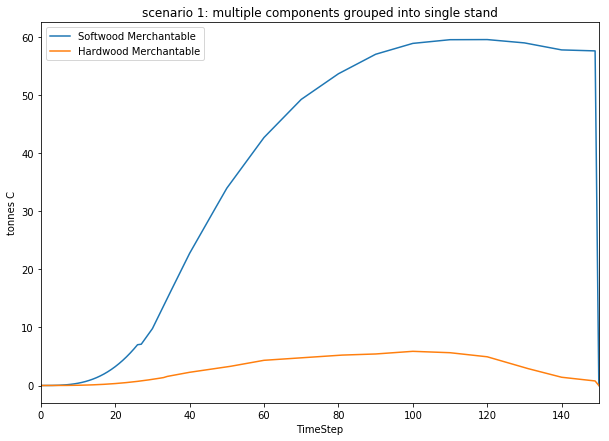

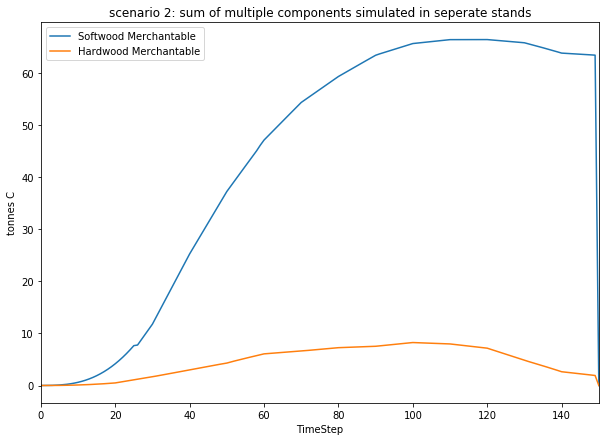

In [9]:
ax = grouped_result.plot(figsize=(10,7),title="scenario 1: multiple components grouped into single stand")
ax.set_ylabel("tonnes C")
ax = summed_component_result.plot(figsize=(10,7),title="scenario 2: sum of multiple components simulated in seperate stands")
ax.set_ylabel("tonnes C")

Text(0, 0.5, 'tonnes C')

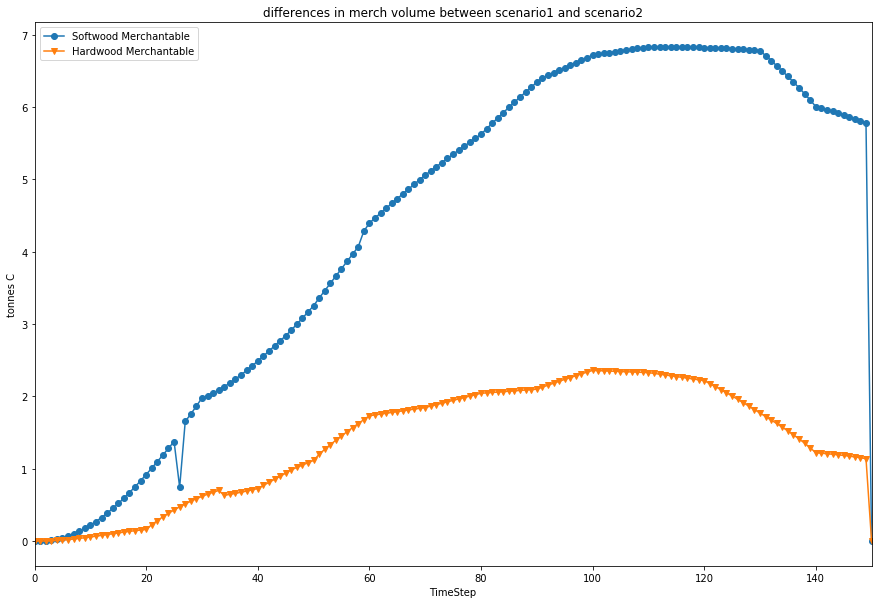

In [10]:

diff = (summed_component_result - grouped_result)
ax = diff.plot(figsize=(15,10),title="differences in merch volume between scenario1 and scenario2")
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i%len(markers)])
ax.legend(ax.get_lines(), diff.columns, loc='best')
ax.set_ylabel("tonnes C")